So, I've copied the table from Kunkle's *Automatic Classification of One-Dimensional Cellular Automata* found in Appendix A.1. I input the data into a dictionary whose keys are Wolfram rule numbers, and whose values are strings representing the class.

In [1]:
from ca_train import ca_classes

Now just a quick check to see that I didn't miss any rules, with a nod to Gauss.

In [2]:
sum(ca_classes.keys()) == 255*256/2

True

Let's see what the distribution of the keys are. And with it, see what all the unique classes are.

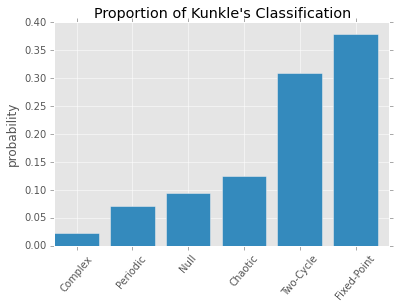

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

proportions, labels = zip(*sorted((v/256, k) for k, v in \
                       Counter(ca_classes.values()).items()))

plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.bar(range(len(labels)), proportions, width=0.8)
ax.set_xticks(np.arange(len(labels)) + 0.4)
ax.set_xticklabels(labels, rotation=50)
ax.set_title("Proportion of Kunkle's Classification")
ax.set_ylabel('probability')
plt.show()

I was also curious to see if you chunked blocks of the classifications, to see if there was a trend in the classification distributions. Specifically, I mean if you chunk the indices into groups, and you tally up their class distributions, how far from a uniform distribution are they? To accomplish see this, we quickly create a [Hellinger *f*-divergence](https://en.wikipedia.org/wiki/Hellinger_distance), which measures the distance between probability distributions:

In [4]:
from scipy.spatial.distance import euclidean

def hellinger(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q))/np.sqrt(2)

Then, given some number of chunks (say 10), we'll divide up the rule numbers into roughly equally sized chunks. Then for each chunk, look at its distribution of classes and see it's distance form uniform via Hellinger. I would expect to see a U-shape, since the rules get more complex toward the center of (0, 256].

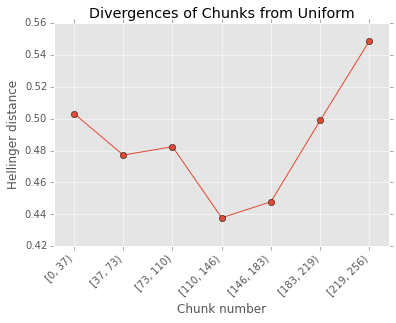

In [13]:
nchunks = 7

# get evenly distributed ranges of indices, with a hack
step = 256//nchunks
residue = 256 % step
start = 0
indices = []
for i in range(nchunks):
    extra = round(residue/(nchunks - i))
    residue -= extra
    indices.append(range(start, start + step + extra))
    start += step + extra

# collect distribution from each chunk and compare to uniform
uniform = [1/step]*len(labels)
divergences = []
distributions = []
for k in range(nchunks):
    dist = {k: v/step for k, v in Counter(ca_classes[i] for i in indices[k]).items()}
    for label in set(labels) - dist.keys():
        dist[label] = 0.0    # fill in missing label proportions
    dist = {k: v/sum(dist.values()) for k, v in dist.items()}    # normalize for small errors
    distributions.append(dist)
    divergences.append(hellinger(uniform, list(dist.values())))
plt.plot(divergences, 'o-')
xtick_labels = ['[{}, {})'.format(indices[i].start, indices[i].stop) \
                                for i in range(nchunks)]
plt.xticks(np.arange(nchunks), xtick_labels, rotation=45, ha='right')
plt.xlim([-0.4, nchunks - 1 + 0.4])
plt.title('Divergences of Chunks from Uniform')
plt.ylabel('Hellinger distance')
plt.xlabel('Chunk number')
plt.show()

Cool! So, it's what you'd expect: the mix of classes gets more and more uniform towards the middle rules. Perhaps this is a more useful perspective:

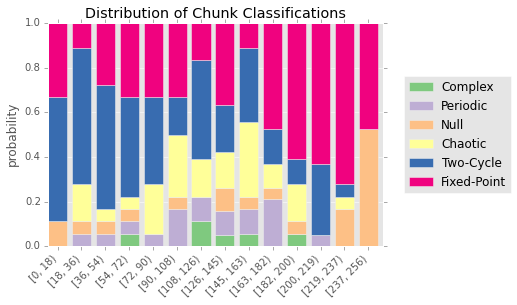

In [6]:
from palettable.colorbrewer.qualitative import Accent_6

bottom = np.zeros(nchunks)
for i, label in enumerate(labels):
    vals = np.array([dist[label] for dist in distributions])
    plt.bar(np.arange(nchunks), vals, bottom=bottom, 
            color=Accent_6.mpl_colors[i], label=label)
    bottom += vals
plt.ylim([0, 1])
plt.xticks(np.arange(nchunks) + 0.8/2, xtick_labels, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.4, 0.5), loc=5)
plt.title('Distribution of Chunk Classifications')
plt.ylabel('probability')
plt.show()